Install Pretrained Models Library

In [1]:
!pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=02e7f9a8cda11eff414cfac075846c8c0f47de44db20f5cec53c6bdbae63e0fe
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


Generate Dataset Labels

In [2]:
import os
import csv

data_dir = "/content/drive/MyDrive/newdataset"  # Update with the path to your dataset
output_csv = "labels.csv"

# Generate labels
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["image", "label"])  # Header

    for label, folder in enumerate(["real", "fake"]):  # real -> 1, fake -> 0
        folder_path = os.path.join(data_dir, folder)
        for img_name in os.listdir(folder_path):
            if img_name.endswith((".jpg", ".png", ".jpeg")):  # Only image files
                writer.writerow([f"{folder}/{img_name}", label])

print(f"Labels saved to {output_csv}")


Labels saved to labels.csv


Prepare Dataset and DataLoader

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

class DeepfakeDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name, label = self.labels[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Load labels from CSV
labels_file = "labels.csv"
labels_data = pd.read_csv(labels_file)
labels = labels_data.values.tolist()  # Convert DataFrame to list

# Split into train and validation sets
train_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)

# Path to dataset folder
data_dir = "/content/drive/MyDrive/newdataset"  # Update with your actual dataset path

# Create datasets and DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = DeepfakeDataset(data_dir, train_labels, transform=transform)
val_dataset = DeepfakeDataset(data_dir, val_labels, transform=transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


 Install Specific Version of Torchvision

In [ ]:
!pip install torchvision==0.15.0 # install previous versions and check

Install timm Library for Pretrained Models

In [ ]:
pip install timm

Define and Initialize Combined Model with Xception and ViT

In [ ]:
import torch
import torch.nn as nn
import timm
from torchvision import models

class CombinedModel(nn.Module):
    def __init__(self, xception, vit):
        super(CombinedModel, self).__init__()
        self.xception = xception
        self.vit = vit
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        xception_features = self.xception(dummy_input).view(1, -1).shape[1]
        vit_features = self.vit(dummy_input).view(1, -1).shape[1]
        self.fc = nn.Linear(xception_features + vit_features, 1)    # Adjust feature sizes if needed

    def forward(self, x):
        x1 = self.xception(x)
        x1 = x1.view(x1.size(0), -1)  # Flatten Xception features

        x2 = self.vit(x)
        x2 = x2.view(x2.size(0), -1)  # Flatten ViT features

        combined = torch.cat((x1, x2), dim=1)
        out = self.fc(combined)
        return torch.sigmoid(out)

# Use timm to load Xception model
xception = timm.create_model('xception', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xception = xception.to(device)

# Use Vision Transformer from torchvision
vit = models.vit_b_16(pretrained=True).to(device)

# Initialize the combined model
model = CombinedModel(xception, vit)
model = model.to(device)  # Ensure model is sent to the correct device (GPU or CPU)


Train and Validate the Combined Model

In [ ]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score

def train_model(model, train_loader, val_loader, epochs=10, device='cuda'):
    # Check CUDA availability before sending model to device
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
        print("CUDA is not available. Training on CPU.")

    model.to(device)  # Ensure the model is on the correct device
    criterion = nn.BCEWithLogitsLoss()  # Loss function for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients before the backward pass
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(1).float())  # Unsqueeze to match output shape
            total_loss += loss.item()

            # Backward pass
            loss.backward()

            # Optimizer step
            optimizer.step()

        # Print the loss after each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

        # Validation after each epoch
        validate_model(model, val_loader, device)

def validate_model(model, val_loader, device='cuda'):
    model.eval()  # Set model to evaluation mode
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Binary threshold

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Calculate accuracy, precision, recall, etc.
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f"Validation - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Train the model
train_model(model, train_loader, val_loader, epochs=5)

Epoch [1/5], Loss: 0.5113
Validation - Accuracy: 0.9612, Precision: 1.0000, Recall: 0.9231
Epoch [2/5], Loss: 0.4871
Validation - Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9923
Epoch [3/5], Loss: 0.4848
Validation - Accuracy: 0.9922, Precision: 0.9923, Recall: 0.9923
Epoch [4/5], Loss: 0.4844
Validation - Accuracy: 0.9961, Precision: 0.9924, Recall: 1.0000
Epoch [5/5], Loss: 0.4835
Validation - Accuracy: 0.9961, Precision: 0.9924, Recall: 1.0000


Graph showing the accuracy of the individual models and the combined model

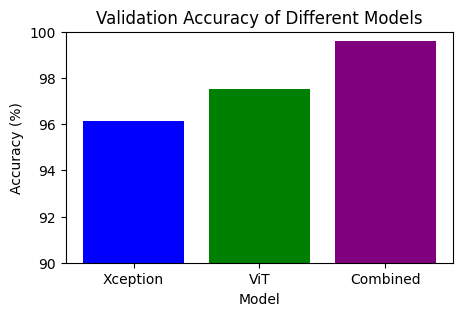

In [ ]:
import matplotlib.pyplot as plt

# Data for the models and their accuracy
models = ['Xception', 'ViT', 'Combined']
accuracy = [96.12, 97.50, 99.61]

# Set the size of the plot (width, height)
plt.figure(figsize=(5, 3))  # Adjust this size as needed

# Create the bar plot
plt.bar(models, accuracy, color=['blue', 'green', 'purple'])

# Set plot title and labels
plt.title('Validation Accuracy of Different Models')
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')

# Set the y-axis limits
plt.ylim(90, 100)

# Display the plot
plt.show()

